# **Entrega 3 - Ciencia de datos aplicada**
## **Reducción de accidentes viales en Bogotá**

### GSD+ & SDM Bogotá​

### **Integrantes**
*   Yachay J. Tolosa Bello – 202315750
*   Kevin Infante Hernández – 201117324​
*   John Vicente Moreno Triviño – 202210162

### **Objetivo**
*   Determinar los lugares y momentos prioritarios para llevar a cabo intervenciones enfocadas en reducir la siniestralidad y orientar el tipo de acciones a desplegar allí.

In [1]:
pip install -r ../requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import numpy as np
import shapely
import matplotlib.pyplot as plt
from holidays import country_holidays
from xgboost import XGBClassifier

from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

Cargamos los datos de accidentes

In [3]:
accidentes_df = pd.read_csv("data/dataset_preparado.csv.gz", low_memory=False)

Cargamos la información geográfica de Bogotá y eliminamos la zona de Sumapaz

In [4]:
mapa_bogota = gpd.read_file("./data/bogota_cadastral.json")
mapa_bogota_no_sumapaz = mapa_bogota.cx[:, 4.45422 :]

In [5]:
def asignar_cuadrante(df, cols=13, rows=21):
    """
    Asigna a cada punto un cuadrante dada el tamaño de maya definida por cols y rows
    """
    
    bottomLeft = (4.45422, -74.22446)
    bottomRight = (4.45422, -73.99208494428275)
    topLeft = (4.833779672812246, -74.22446)
    topRight = (4.833779672812246, -73.99208494428275)
    
    cols = np.linspace(bottomLeft[1], bottomRight[1], num=cols + 1)
    rows = np.linspace(bottomLeft[0], topLeft[0], num=rows + 1)
    col = np.searchsorted(cols, df["X"]) - 1
    row = np.searchsorted(rows, df["Y"]) - 1
    df['cuadrante'] = row * (len(cols) - 1) + col

    cuadrantes_cord = []
    for i in range(len(rows) - 1):
        for j in range(len(cols) - 1):
            poly = shapely.geometry.box(cols[j], rows[i], cols[j + 1], rows[i + 1])
            cuadrantes_cord.append(poly)
    
    grid = gpd.GeoDataFrame(
        cuadrantes_cord, columns=["geometry"], crs=mapa_bogota_no_sumapaz.crs
    ).sjoin(mapa_bogota_no_sumapaz)[['geometry']].drop_duplicates()

    return df, grid



def enriquecer_fechas(df_base):

    df_base["hora"] = df_base.fecha_y_hora.dt.hour
    df_base["semana_del_año"] = df_base.fecha_y_hora.dt.isocalendar().week
    df_base["dia_de_la_semana"] = df_base.fecha_y_hora.dt.weekday
    df_base["mes"] = df_base.fecha_y_hora.dt.month
    
    colombian_holidays = country_holidays("CO")

    holidays = pd.DataFrame(
        index=pd.date_range(df_base.fecha_y_hora.min(), df_base.fecha_y_hora.max(), freq="d", normalize=True)
    )
    
    holidays["festivo"] = np.where(
        holidays.index.map(lambda x: x in colombian_holidays), 1, 0
    )
    
    df_base["fecha_truncada"] = df_base["fecha_y_hora"].dt.floor("d")
    
    df_base = df_base.join(holidays, on="fecha_truncada").drop(columns="fecha_truncada")

    return df_base
    

def crear_dataset(df, lapso="1h", cols=13, rows=21):
    """
    Crea un dataset de una grilla espacio temporal y marca cada cuadrante según el número de accidentes ocurridos
    """

    # Asignamos los cuadrantes
    df, grid = asignar_cuadrante(df, cols, rows)

    fecha_y_hora = pd.to_datetime(df["FECHA_OCURRENCIA_ACC"].str[:11] + df["HORA_OCURRENCIA_ACC"].str[:2])
    
    fechas = pd.DataFrame(
        pd.date_range( fecha_y_hora.min(), fecha_y_hora.max(), freq="1h"),
        columns=["fecha_y_hora"],
    )
    
    cuadrantes = pd.DataFrame(
        df["cuadrante"].unique(),
        columns=["cuadrante"],
    )
    
    # Creamos una tabla del producto carteciano entre los cuadrantes y las fechas
    df_base = fechas.merge(cuadrantes, how="cross")

    # Agregamos el número de accidentes y marcamos en cero cuando no hay accidentes. 
    df_base = df_base.join(
        df.groupby([fecha_y_hora, "cuadrante"]).size().rename("n_accidentes"),
        on=["fecha_y_hora", "cuadrante"]
    ).fillna(0)
    
    # Re-muestreamos para tener los intervalos de tiempo del tamaño deseado
    df = df_base.groupby(["cuadrante", pd.Grouper(key="fecha_y_hora", freq=lapso)], as_index=False).sum()
    
    # creamos la variable accidentes indicando si hubo o no accidentes
    df["accidentes"] = np.where(df["n_accidentes"] > 1, 1, 0)

    df = enriquecer_fechas(df)
    
    df = df.drop(columns=['n_accidentes'])
    
    df = df.pivot(
        columns="cuadrante",
        values='accidentes',
        index=['fecha_y_hora',  'hora', 'semana_del_año', 'dia_de_la_semana', 'mes', 'festivo']
    ).reset_index().set_index('fecha_y_hora').sort_index()

    return df

In [6]:
rows = 6
cols = 12
df = crear_dataset(accidentes_df, lapso="4h", rows=rows, cols=cols)

In [7]:
X = df
y = df[df.columns.difference(['hora', 'semana_del_año', 'dia_de_la_semana', 'mes', 'festivo'])]

In [8]:
X.head()

cuadrante,hora,semana_del_año,dia_de_la_semana,mes,festivo,3,4,5,6,7,...,54,55,56,57,58,66,67,68,69,70
fecha_y_hora,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0,1,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,4,1,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 08:00:00,8,1,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00,12,1,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 16:00:00,16,1,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y.head()

cuadrante,3,4,5,6,7,14,15,16,17,18,...,54,55,56,57,58,66,67,68,69,70
fecha_y_hora,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 08:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 16:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.data import Dataset

In [55]:
periodos_predichos = 6 * 7
longitud_secuencia = 60
batch_size = 128

train_size = len(X) * 70 // 100
val_size = len(X) * 20 // 100

X_train = timeseries_dataset_from_array(
    X.values.astype("float")[: train_size - periodos_predichos], 
    targets=None, 
    sequence_length=longitud_secuencia, 
    batch_size=batch_size
)

y_train = timeseries_dataset_from_array(
    y.values.astype("float")[longitud_secuencia:train_size],
    targets=None,
    sequence_length=periodos_predichos,
    batch_size=batch_size
)

dataset_train = Dataset.zip((X_train, y_train)).shuffle(10 * batch_size)



X_val = timeseries_dataset_from_array(
    X.values.astype("float")[train_size - periodos_predichos : train_size + val_size - periodos_predichos], 
    targets=None, 
    sequence_length=longitud_secuencia, 
    batch_size=batch_size
)

y_val = timeseries_dataset_from_array(
    y.values.astype("float")[train_size + longitud_secuencia:train_size + val_size],
    targets=None,
    sequence_length=periodos_predichos,
    batch_size=batch_size
)

dataset_val = Dataset.zip((X_val, y_val))


X_test = timeseries_dataset_from_array(
    X.values.astype("float")[train_size + val_size - periodos_predichos : -periodos_predichos], 
    targets=None, 
    sequence_length=longitud_secuencia, 
    batch_size=batch_size
)

y_test = timeseries_dataset_from_array(
    y.values.astype("float")[train_size + val_size + longitud_secuencia:],
    targets=None,
    sequence_length=periodos_predichos,
    batch_size=batch_size
)

dataset_test = Dataset.zip((X_test, y_test))


In [56]:
for a in dataset_train.as_numpy_iterator():
    print(a[1].shape)
    break

(128, 42, 46)


In [57]:
import os

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/cuda/"

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Normalization, Reshape, Input, BatchNormalization, RepeatVector

In [59]:
nomalizar = Normalization()
nomalizar.adapt(X_train)

In [60]:
model = Sequential()
model.add(Input(shape=(1, X.shape[1])))

model.add(BatchNormalization())
# model.add(LSTM(16, return_sequences=True))
model.add(LSTM(y.shape[1], return_sequences=True))
model.add(LSTM(16))
model.add(Dense(16, activation="relu"))
model.add(RepeatVector(6 * 7))
model.add(LSTM(y.shape[1], return_sequences=True))

# model.add(Dense(y_train.shape[1], activation="sigmoid"))

In [61]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 1, 51)             204       
 chNormalization)                                                
                                                                 
 lstm_12 (LSTM)              (None, 1, 46)             18032     
                                                                 
 lstm_13 (LSTM)              (None, 16)                4032      
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 repeat_vector_4 (RepeatVec  (None, 42, 16)            0         
 tor)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 42, 46)           

In [62]:
from tensorflow.keras.metrics import BinaryAccuracy, F1Score, Recall

model.compile(loss='binary_crossentropy', optimizer='adam')

In [63]:
model.fit(dataset_train, epochs=100, validation_data=dataset_val)

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 0.7444

InvalidArgumentError: Graph execution error:

Detected at node binary_crossentropy/mul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/maini/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/maini/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/home/maini/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/maini/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/maini/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/maini/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/maini/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/maini/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/maini/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_96127/2908015086.py", line 1, in <module>

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1856, in fit

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1919, in test_step

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 2532, in binary_crossentropy

  File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/backend.py", line 5830, in binary_crossentropy

Incompatible shapes: [116,42,46] vs. [128,42,46]
	 [[{{node binary_crossentropy/mul}}]] [Op:__inference_test_function_38882]

<Axes: >

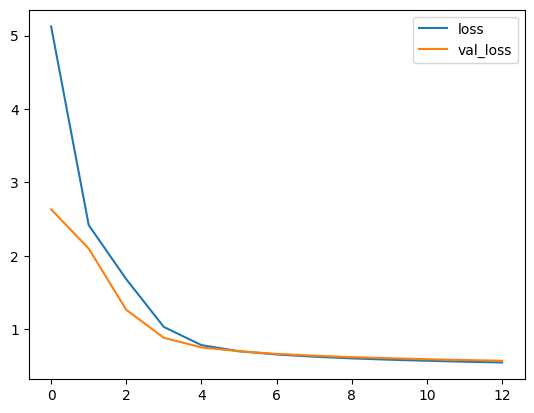

In [523]:
pd.DataFrame(model.history.history).plot()

In [524]:
pred = model.predict(X_test)

41/41 [==============================] - 1s 3ms/step


In [525]:
pred.shape

(5217, 42, 4)

In [533]:
model.predict(X.values.astype("float")[train_size : -6 * 7])

ValueError: in user code:

    File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/maini/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_61" is incompatible with the layer: expected shape=(None, 1, 9), found shape=(None, 9)


In [484]:
pred.shape

(17655, 42, 4)

In [485]:
y_test

<_BatchDataset element_spec=TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None)>

In [15]:
preproc = make_column_transformer(
    (sin_transformer(24), ["hora"]),
    (cos_transformer(24), ["hora"]),
    (sin_transformer(7), ["dia_de_la_semana"]),
    (cos_transformer(7), ["dia_de_la_semana"]),
    (sin_transformer(12), ["mes"]),
    (cos_transformer(12), ["mes"]),
    (sin_transformer(53), ["semana_del_año"]),
    (cos_transformer(53), ["semana_del_año"]),
    (
        StandardScaler(),
        [
             'accidente_14_dias_media_móvil',
             'accidente_21_dias_media_móvil',
             'accidente_28_dias_media_móvil',
             'accidentes_8_media_móvil_día',
             'accidentes_14_media_móvil_día',
             'accidentes_21_media_móvil_día',
             'accidentes_28_media_móvil_día'
        ]
    ),
)

## Regresión logística

In [ ]:
from imblearn.over_sampling import SMOTE

lr_model = Pipeline([
   ("preprocesamiento", preproc),
   ("remuestreo", SMOTE()),
   ("modelo", LogisticRegression(class_weight="balanced")),
])

grid = [
    {
        "modelo__C": [0.1, 1, 10, 100],
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__penalty': ['l2'],
    },
    {
        "modelo__C": [0.1, 1, 10, 100],
        "modelo__l1_ratio": [0.1, 0.5, 1],
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__penalty': ['elasticnet'],
        'modelo__solver': ['saga'] # lbfgs no funciona con elasticnet
    }
]

lr_search = GridSearchCV(lr_model, grid, scoring="f1", cv=TimeSeriesSplit(), n_jobs=16)

lr_search.fit(X_train, y_train)

pd.Series(lr_search.best_params_, name="valor").to_frame()

In [ ]:
joblib.dump(lr_model, "lr_model.joblib")

## Random Forest

In [ ]:
rf_model = Pipeline([
   ("preprocesamiento", preproc),
   ("remuestreo", SMOTE()),
   ("modelo", RandomForestClassifier(class_weight="balanced", n_jobs=-1)),
])

grid = [
    {
        'remuestreo': ['passthrough', SMOTE(k_neighbors=5), SMOTE(k_neighbors=10), SMOTE(k_neighbors=20)],
        'modelo__n_estimators': [100, 200, 400],
    }
]

rf_search = GridSearchCV(rf_model, grid, scoring="f1", cv=TimeSeriesSplit())

rf_search.fit(X_train, y_train)

pd.Series(rf_search.best_params_, name="valor").to_frame()

In [106]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

modelo = Pipeline([
   ("preprocesamiento", preproc),
   ("remuestreo", SMOTE()),
   ("modelo", XGBClassifier(scale_pos_weight=4)),
])

modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('functiontransformer-1',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function sin_transform at 0x7fa15972aca0>,
                                                                      kw_args={'period': 24}),
                                                  ['hora']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function cos_transform at 0x7fa159728f40>,
                                                                      kw_args...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

<Axes: title={'center': 'Características utilizadas según su importancia en el modelo'}>

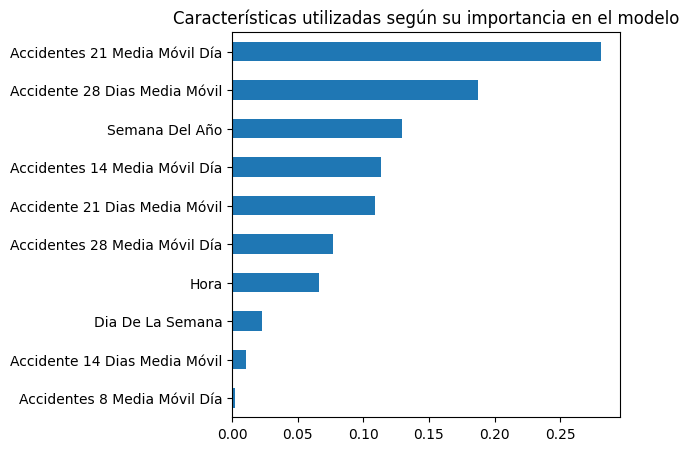

In [107]:
caracteristicas  = pd.Series(
    modelo[-1].feature_importances_,
    index=modelo[:-1].get_feature_names_out()
)

caracteristicas.groupby(
    caracteristicas.index.map(lambda x: x.split("__")[-1].replace("_", " ").title())
).sum().sort_values().plot.barh(title="Características utilizadas según su importancia en el modelo", figsize=(5,5))

In [59]:
from sklearn.metrics import classification_report

print(
    classification_report(y_test, modelo.predict(X_test))
)

              precision    recall  f1-score   support

           0       0.95      0.75      0.84    150928
           1       0.40      0.81      0.54     31187

    accuracy                           0.76    182115
   macro avg       0.68      0.78      0.69    182115
weighted avg       0.86      0.76      0.79    182115



# Entrenando modelos para diferentes tamaños de grilla

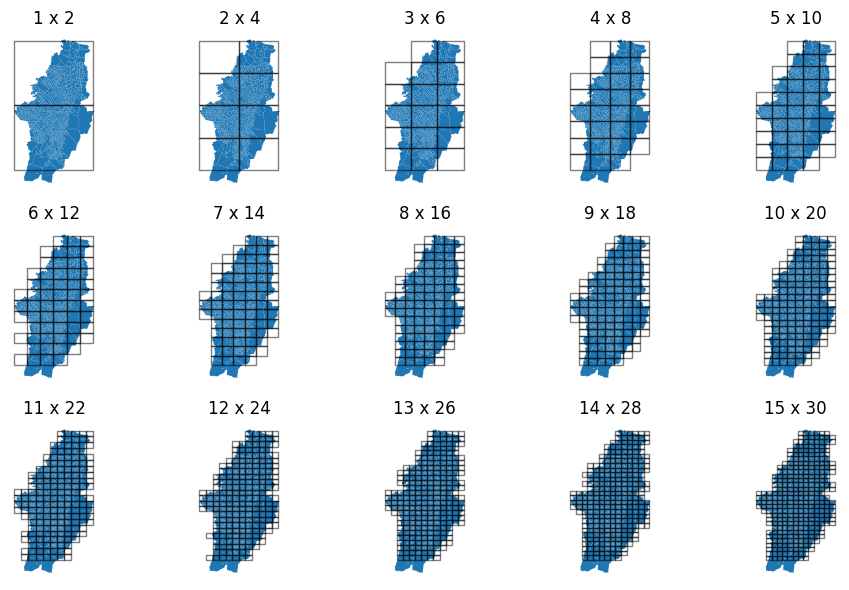

In [66]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for cols, ax in enumerate(axes.flat):
    cols = cols + 1
    rows = 2 * cols
    df, grid = asignar_cuadrante(accidentes_df, cols=cols, rows=rows)
    mapa_bogota_no_sumapaz.plot(ax=ax)
    grid.plot(fc="none", ec="black", alpha=0.5, ax=ax)
    ax.set_title(f"{cols} x {rows}")
    ax.axis("off")
    
plt.tight_layout()